## Outline
    1. Generators 
    2. Augmentation
    3. Training 
    4. Callbacks
    5. Inference

        
Convolutional networks ([ConvNets](https://en.wikipedia.org/wiki/Convolutional_neural_network)) have had great success in large-scale image
and video recognition which has become possible due to the large public image repositories,
such as [ImageNet](http://www.image-net.org/), and high-performance computing systems, such as GPUs
or large-scale distributed clusters.

[keras](https://keras.io/) is a user friendly framework that allows for easy and fast prototyping, supports both convolutional and recurrent networks, and runs seasmlessly on CPU and GPU.


In this notebook we will walk through the steps required to build, train and monitor an image classifier.

---


## 1. Generators

The easiest way to feed data into a network in `keras` is through a generator. A generator allows us to easily define the source and processing of our data. Here is a simple example:

Found 92 images belonging to 12 classes.
Some of our training data:


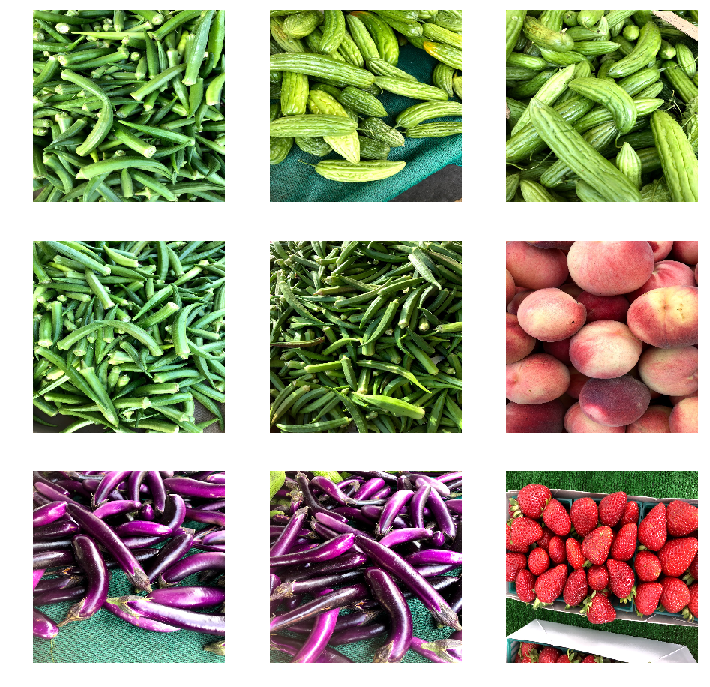

In [19]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize our generator, choosing to shuffle our images and the batch size.
gen = ImageDataGenerator().flow_from_directory('data/farmer_market',
                                               shuffle=True, 
                                               batch_size=9)
# Here we see its output for the first batch.
# This should be the batch of inputs with the matching labels


# Let's look at how our data looks like
print("Some of our training data:")
v_dim, u_dim = (3,3)
fig, ax = plt.subplots(u_dim, v_dim, figsize=(12,12))
count = 0
for i in range(v_dim):
    for j in range (u_dim):
        ax[i, j].imshow(images[count].astype(np.uint8))
        ax[i, j].axis('off')
        count += 1


---

## 2. Data Augmentation
In a general sense, data augmentation allows us to work with more data points than we have. Specifically for images, this means introducing rotations, scaling, brightness, saturation, zooming and many other perturbations to make our model more robust and unbiased. 

Here is an example of how that looks:

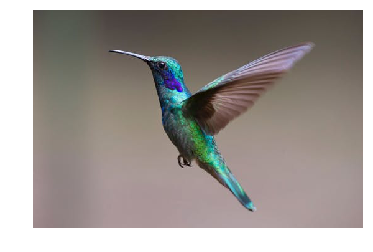

In [20]:
bird_img = cv2.imread('plots/bird.jpeg')[:,:,::-1]
plt.axis('off')
plt.imshow(bird_img)

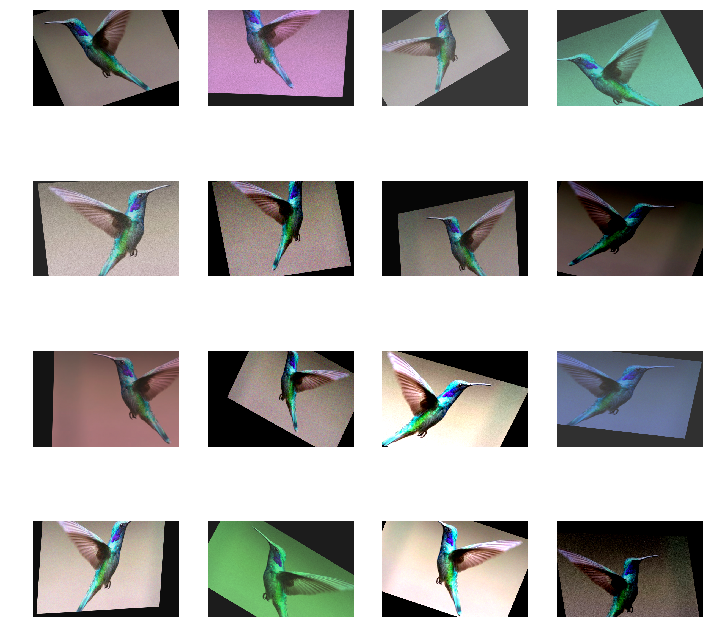

In [22]:
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.15)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.55, 1.8)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.7),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.5, 1.5), per_channel=0.4),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-35, 35),
        shear=(-12, 12)
    )
    ], random_order=True)

bird_imgs = [bird_img]*16

aug_bird_imgs = seq.augment_images(bird_imgs)

v_dim, u_dim = (4,4)
fig, ax = plt.subplots(u_dim, v_dim, figsize=(12,12))
count = 0
for i in range(v_dim):
    for j in range (u_dim):
        ax[i, j].imshow(aug_bird_imgs[count].astype(np.uint8))
        ax[i, j].axis('off')
        count += 1


`keras` makes it very easy to combine the augmentation with the generator. For example, we can easily include the previous augmentations with:
```python
rescaled_aug = lambda x: seq.augment_image(x)/255
datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=rescaled_aug)
```
If we want simpler (i.e. less flexible) augmentation we can also use `ImageDataGenerator`'s arguments as we will do below. 

#### Note about object detection

If instead of image clasification we were doing object detection (where we need to pass class label as well as bounding box coordinates) we might consider using custom augmentation, and maybe writing our own generator by overloading `Sequence` (you can check out an example of this in my `keras` [implementation of the object detector YOLO v2](https://github.com/ksanjeevan/dourflow/blob/master/net/netgen.py)).

---

Given that our `farmer-market` dataset is small (FOR NOW!), we will proceed with an equivalent task on the [kaggle](https://www.kaggle.com) dataset [flowers-recognition](https://www.kaggle.com/alxmamaev/flowers-recognition).
The dataset can be downloaded using the kaggle API, by running:
```bash
kaggle datasets download -d alxmamaev/flowers-recognition
```

or from my google drive account [here](https://drive.google.com/file/d/1blNYuDVxFhUh-XmL8QcQj2iCfrpNZjDa/view?usp=sharing).

Let's use `ImageDataGenerator`'s simple augmentation and see how the data looks:


Found 3243 images belonging to 5 classes.
Found 1080 images belonging to 5 classes.


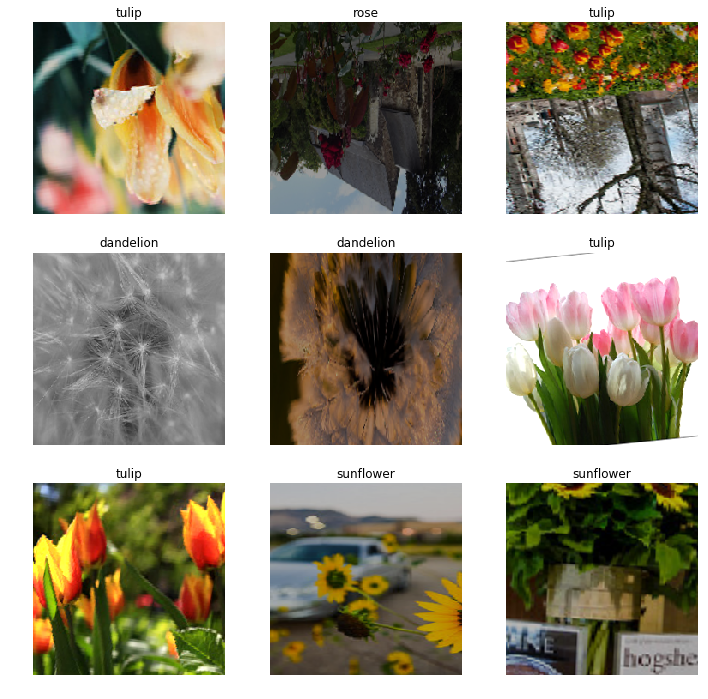

In [25]:
KAGGLE_PATH = '../flowers'

# Read more here: https://keras.io/preprocessing/image/#imagedatagenerator-class
datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #channel_shift_range=0.1,
    brightness_range=[0.6,1.4],
    zoom_range=[.4, 1.],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25,
    fill_mode='nearest')


# Some of the generator arguments before we call `flow`
gen_args = dict(
    directory = KAGGLE_PATH,
    target_size = (224,224),
    class_mode = 'sparse',
    batch_size=16,
    shuffle=True
)

# Create training and validation generators
train_gen = datagen.flow_from_directory(subset='training', **gen_args)
val_gen = datagen.flow_from_directory(subset='validation', **gen_args)

# Important to store the mapping of index -> class label
# for inference later
decode_map = {v: k for k, v in train_gen.class_indices.items()}

# Let's look at a few
images, labels = train_gen[0]
v_dim, u_dim = (3,3)
fig, ax = plt.subplots(u_dim, v_dim, figsize=(12,12))
count = 0
for i in range(v_dim):
    for j in range (u_dim):
        ax[i, j].imshow((255*images[count]).astype(np.uint8))
        ax[i, j].axis('off')
        ax[i, j].set_title(decode_map[labels[count]])
    
        count += 1
        

---

## 3. Training
### 3.1 Model selection
It's now time to begin training our network (we won't get into all the different architectures). Since classification is a well solved problem, we will use VGG16 for its high performance and not bother trying to reinvent the wheel.

### 3.2 Transfer learning
Another reason to use a well known architecture is that researchers who spend weeks carefully training them usually publish their weights, and we can take advantage of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). `keras` makes this again very easy by automatically downloading the weights for [ImageNet](http://www.image-net.org/) when initializing the model (we could also choose to train from scratch but that is not a trivial task).


Let's take a look at VGG16:

In [6]:
from keras.applications import VGG16
vgg_base = VGG16()
print(vgg_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
from keras.layers import Dense
from keras.models import Model

# To do transfer learning we will have to remove the last layer and\
# replace it with a randomized one of appropiate size.
def update_model(model, out_size):
    new_out = Dense(
        out_size, 
        activation='softmax', 
        name='predictions')(model.layers[-2].output)

    return Model(inputs=model.inputs, outputs=new_out)

## 4. Callbacks

Callbacks allow us to run evaluations and record metrics at the end of an epoch, and write them to `tensorboard` or print them to screen for monitoring. When doing classification it's a good idea to keep track of precision and recall.

Before we begin training we'll take a look at the `Callback` class:

In [8]:
from keras.callbacks import Callback
from tqdm import tqdm
from sklearn.metrics import recall_score, precision_score
import pandas as pd

class Metrics(Callback):
    
    def __init__(self, generator):
        self.generator = generator
        super(Metrics, self).__init__()
        
    def on_train_begin(self, logs={}):
        self.val_losses = [float('inf')]
        self.metrics = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.val_losses.append(logs['val_loss'])
        
        if self.val_losses[-2] > self.val_losses[-1]:
            
            y_true = []; y_pred = []
            for batch in range(len(self.generator)):
                images, labels = self.generator[batch]
                y_pred.append(self.model.predict(images))
                y_true.append(labels)
            
            y_pred = np.concatenate(y_pred, axis=0)    
            y_true = np.concatenate(y_true, axis=0)    
            y_pred_winner = np.argmax(y_pred, axis=-1)
            
            recall = recall_score(y_true, y_pred_winner, average=None)
            precision = precision_score(y_true, y_pred_winner, average=None)
            self.metrics.append({'precision':precision, 'recall':recall})
        
        # Get the window=3 moving average
        r = np.mean([m['recall'] for m in self.metrics[-3:]], axis=0)
        p = np.mean([m['precision'] for m in self.metrics[-3:]], axis=0)
        index = [decode_map[i] for i in range(len(p))]
        
        df = pd.DataFrame(np.transpose([p, r]), index=index, columns=['Precision', 'Recall'])
        
        print(len(self.metrics))
        print(df)
        

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
# Let's begin training

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

LR = 0.0002
TRAIN_STEPS, VAL_STEPS = 100, 20
NUM_EPOCHS = 100
PATIENCE=3

model = update_model(vgg_base, train_gen.num_classes)

early_stop = EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=PATIENCE,
            mode='min',
            verbose=1)

checkpoint = ModelCheckpoint(
        './tutorial_weights.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        period=1,
        save_weights_only=True)

metrics = Metrics(val_gen)

model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(lr=LR), 
        metrics=['acc'])

train_data = model.fit_generator(
        train_gen,
        steps_per_epoch=TRAIN_STEPS,
        epochs=NUM_EPOCHS,
        validation_data=val_gen,
        validation_steps=VAL_STEPS,
        callbacks=[checkpoint, early_stop, metrics])

Epoch 1/100
100/100 [==============================] - 38s 383ms/step - loss: 2.6868 - acc: 0.1256 - val_loss: 2.5326 - val_acc: 0.1348

Epoch 00001: val_loss improved from inf to 2.53264, saving model to ./tutorial_weights.h5
1
               Precision  Recall
bitter_melon    0.000000     0.0
bok_choy        0.000000     0.0
carrot          0.000000     0.0
cauliflower     0.000000     0.0
cherry_tomato   0.000000     0.0
eggplant        0.000000     0.0
green_bean      0.000000     0.0
okra            0.130435     1.0
onion           0.000000     0.0
strawberry      0.000000     0.0
white_peach     0.000000     0.0
yellow_peach    0.000000     0.0
Epoch 2/100
  1/100 [..............................] - ETA: 18s - loss: 2.5381 - acc: 0.0625

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


100/100 [==============================] - 33s 327ms/step - loss: 2.1915 - acc: 0.1957 - val_loss: 1.7679 - val_acc: 0.3478

Epoch 00002: val_loss improved from 2.53264 to 1.76792, saving model to ./tutorial_weights.h5
2
               Precision  Recall
bitter_melon    0.000000    0.00
bok_choy        0.000000    0.00
carrot          0.000000    0.00
cauliflower     0.000000    0.00
cherry_tomato   0.000000    0.00
eggplant        0.000000    0.00
green_bean      0.000000    0.00
okra            0.215217    1.00
onion           0.000000    0.00
strawberry      0.222222    0.50
white_peach     0.166667    0.25
yellow_peach    0.500000    0.50
Epoch 3/100
100/100 [==============================] - 33s 325ms/step - loss: 1.7791 - acc: 0.3042 - val_loss: 1.5619 - val_acc: 0.4391

Epoch 00003: val_loss improved from 1.76792 to 1.56187, saving model to ./tutorial_weights.h5
3
               Precision    Recall
bitter_melon    0.333333  0.166667
bok_choy        0.000000  0.000000
carrot      

We can then look at `train_data.history` to plot some training info: 

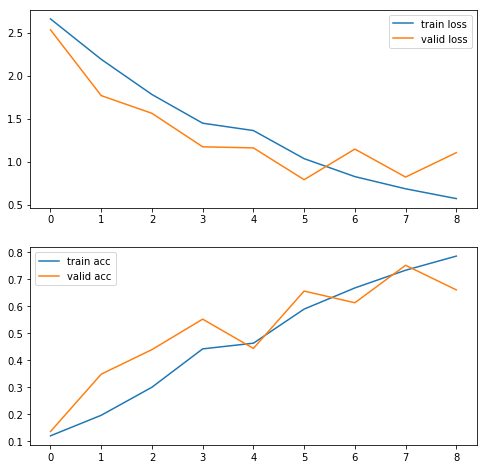

In [11]:

fig, ax = plt.subplots(2, 1, figsize=(8,8))


df = pd.DataFrame()
df['train loss'] = train_data.history['loss']
df['valid loss'] = train_data.history['val_loss']

df2 = pd.DataFrame()
df2['train acc'] = train_data.history['acc']
df2['valid acc'] = train_data.history['val_acc']

df.plot(ax=ax[0])
df2.plot(ax=ax[1])

plt.show()

## 5. Inference

We can now use the trained model to run inference on new images:

In [14]:
def preprocess_image(image):
    return np.expand_dims(cv2.resize(image, (224,224)), 0) / 1

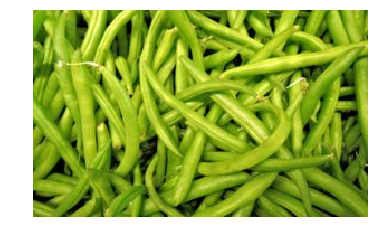

In [13]:
img = cv2.imread('plots/prova.jpg')[:,:,::-1]
plt.axis('off')
plt.imshow(img)

In [23]:
from keras.applications import VGG16
model = update_model(VGG16(), 12)

#model.load_weights('tutorial_weights.h5')
model.load_weights('logs/run_2/trained_weights.h5')
output = model.predict( preprocess_image(img) )[0]

winning_ind = np.argmax(output)

label = decode_map[winning_ind]
score = output[winning_ind]


print('Prediction: %s (%.2f %%)'%(label, score*100))

Prediction: white_peach (100.00 %)
